# <center> <font color='blue'> **Advancing Passive Microwave Retrievals of Precipitation using CloudSat and GPM Coincidences: Integration of Machine Learning with a Bayesian Algorithm** <center>

#### <center> <font color='balck'> Reyhaneh Rahimi, Ardeshir Ebtehaj <center>
#### <center> Saint Anthony Falls Laboratory, Department of Civil Environmental and Geo- Engineering, 
#### <center> University of Minnesota <center>
#### <center> Date: Agust, 2024 (rev 01)

---
<p align="justify"> This notebook representes the results of an algorithm, called the ShARP_ML for passive microwave retrieval of precipitation. The algorithm relies on a dense and deep neural network architecture that uses coincidences of brightness temperatures (TB) from the Global Precipitation Measurment (GPM) satellite Microwave Imager (GMI) and active precipitation retrievals from the Dual-frequency Precipitation Radar (DPR) onboard the GPM as well as those from the CloudSat Cloud Profiling Radar (CPR). The algorithm first detects the precipitation occurrence and phase using XGboost algorithm and then estimates its rate, while conditioning the results to some key cloud microphysical and environmental variables as further explained later on in Section 1.2. The results indicate that we can reconstruct the DPR rainfall and CPR snowfall with the detection probability of more than 0.95 while the probability of false alarm remains below 0.01, respectively. Given that precipitation is occurred, the unbiased root mean squared errors in estimation of rainfall (snowfall) rate using DPR (CPR) data is less than 0.8 (0.1) $\rm mm.hr^{-1}$ over oceans and land. . 

This notebook is organized as follows. Section 1, describes the data including the GPM and CloudSat products as well as the ERA5 reanalysis data from the European Centre for Medium-Range Weather Forecasts (ECMWF). Section 2 shows the result of detection and estmation over ocean, and the last section provides an example for precipitation orbital retrieval using the proposed algorithm.
The detailed architerure of the networks and models are presented in model.py file.





   


In [1]:
import utils as utils
import os
import pickle
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy.io import loadmat
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, linear_model, datasets
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
    make_scorer,
    f1_score,
)
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import Ridge
from scikeras.wrappers import KerasClassifier
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Dense,
    Activation,
    Dropout,
    Input,
    BatchNormalization,
)
from tensorflow.keras import layers, Sequential
from tensorflow.keras import Model
from tabulate import tabulate


2024-08-09 01:26:47.981597: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Loading the data


In [2]:
# Below is the subset of ocean dataframe to test the trained models
# This is 50% of the originl testset
surf_type = 'ocean'
path = '/panfs/jay/groups/0/ebtehaj/rahim035/sajad_s/project-4/revision'
data = pd.read_csv(os.path.join(path, f'data/{surf_type}_subset_test.csv'))
data.head(10)
X_tst, y_tst = utils.process_and_normalize(data, surf_type)



### Loading the models

In [69]:
# The models are loaded here, Detailed nemork are in models.py
path_models   = '/panfs/jay/groups/0/ebtehaj/rahim035/sajad_s/project-4/revision/models/'
path_features = '/panfs/jay/groups/0/ebtehaj/rahim035/sajad_s/project-4/revision/features/'

model_dtc_xgb = pickle.load(open((path_models+f'{surf_type}_det_xgb.pickle.dat'), "rb"))

model_dtc_dnn = keras.models.load_model(path_models + f"{surf_type}_det_dnn_2.h5")

model_rtv_rain = keras.models.load_model(path_models + f'{surf_type}_est_FL_rain_10class.h5',\
                                                   custom_objects={'CategoricalFocalLoss': utils.CategoricalFocalLoss(alpha=0.25, gamma=2)}, compile=False)

model_rtv_snow = keras.models.load_model(path_models + f'{surf_type}_est_FL_snow_10class.h5',\
                                                  custom_objects={'CategoricalFocalLoss': utils.CategoricalFocalLoss(alpha=0.25, gamma=2)}, compile=False)

features_data = sio.loadmat(path_features + f'feature_dic_{surf_type}.mat')
X_trn_rain_features = features_data[f'X_trn_rain_features_{surf_type}']
y_trn_rain = features_data[f'y_trn_rain_{surf_type}'][:,1]

X_trn_snow_features = features_data[f'X_trn_snow_features_{surf_type}']
y_trn_snow = features_data[f'y_trn_snow_{surf_type}'][:,1]

In [5]:
model_dtc_dnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 50)                950       
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 fc_1 (Dense)                (None, 50)                2550      
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 fc_2 (Dense)                (None, 50)                2550      
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 fc_3 (Dense)                (None, 50)               

In [6]:
# Predicting phase
prd_xgb = model_dtc_xgb.predict(X_tst)
print(classification_report(y_tst[:,0], prd_xgb, labels = [0,1,2], target_names = ['clear', 'rain', 'snow']))


              precision    recall  f1-score   support

       clear       1.00      1.00      1.00     92136
        rain       1.00      0.99      0.99      7474
        snow       0.95      0.99      0.97      2279

    accuracy                           1.00    101889
   macro avg       0.98      0.99      0.99    101889
weighted avg       1.00      1.00      1.00    101889



In [7]:
# print more scores
utils.score(y_tst[:,0], prd_xgb)

+----------+--------+--------+
| Metric   |   Rain |   Snow |
+==========+========+========+
| TPR      |  0.987 |  0.986 |
+----------+--------+--------+
| FPR      |  0     |  0.001 |
+----------+--------+--------+
| AUC      |  0.994 |  0.992 |
+----------+--------+--------+
| F1 Score |  0.992 |  0.969 |
+----------+--------+--------+


(0.0, 1.0, 0.0, 1.0)

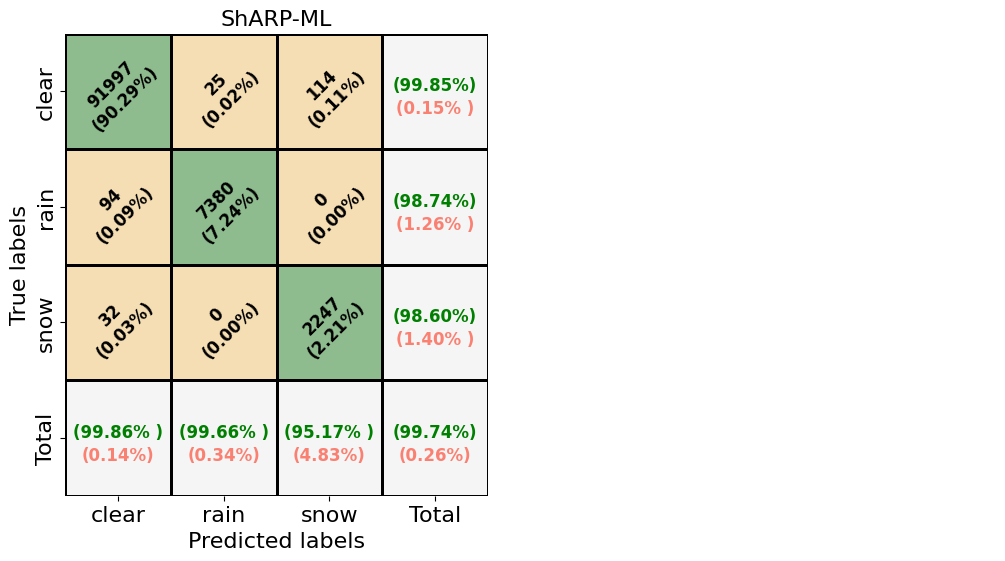

In [8]:
# plot the confusion matrix
fig, axes = plt.subplots(1,2,figsize=(12, 6))
axes = axes.ravel()
utils.plot_detailed_confusion_matrix(y_tst[:,0], prd_xgb, axes[0], 'ShARP-ML', True, True)
axes[1].axis('off')


### Estimation using ShARP_ML

In [9]:
import tensorflow as tf
new_input_rain   = model_rtv_rain.input
new_output_rain  = model_rtv_rain.get_layer('fc_3').output
model_rtv_rain_ = tf.keras.Model(new_input_rain, new_output_rain)

new_input_snow   = model_rtv_snow.input
new_output_snow  = model_rtv_snow.get_layer('fc_3').output
model_rtv_snow_ = tf.keras.Model(new_input_snow, new_output_snow)


In [10]:
feature_prd_snow = model_rtv_snow_.predict(X_tst)
feature_prd_rain = model_rtv_rain_.predict(X_tst)


3185/3185 [==============================] - 3s 970us/step


In [11]:
k_nn_rain, k_nn_snow = 20, 20
rate_rain_pred_knn, indices_rain = utils.loc_rate(X_trn_rain_features, feature_prd_rain, y_trn_rain, k_nn_rain)
rate_snow_pred_knn, indices_snow = utils.loc_rate(X_trn_snow_features, feature_prd_snow, y_trn_snow, k_nn_snow)

rate_rain_pred_ridge = utils.ridge_estimation(
    X_trn_rain_features, feature_prd_rain, indices_rain, y_trn_rain, rate_rain_pred_knn
    )

rate_snow_pred_ridge = utils.ridge_estimation(
    X_trn_snow_features, feature_prd_snow, indices_snow, y_trn_snow, rate_snow_pred_knn
    )


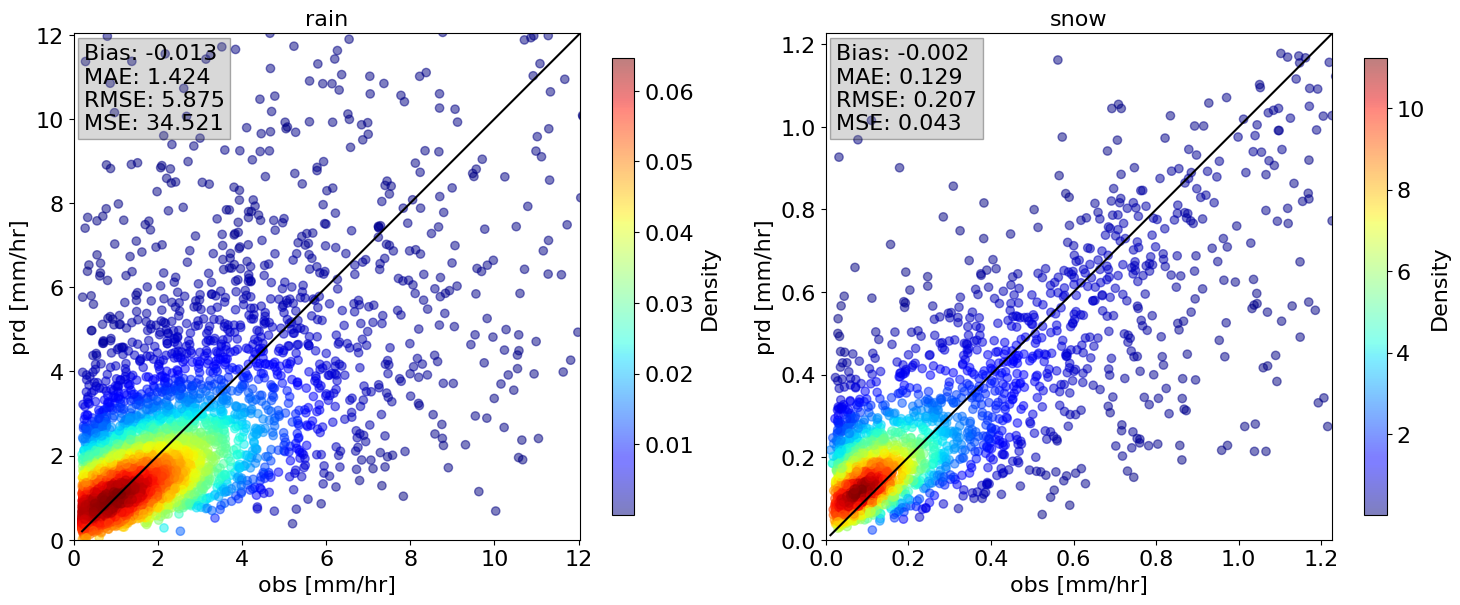

In [12]:
# The result are different from the paper since testset is 20% of the original testset
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
plt.rcParams.update({'font.size': 16})
# Call the plot function for each subplot
utils.plot_density_scatter(axes[0], y_tst, rate_rain_pred_ridge, prd_xgb, 1, 0)
utils.plot_density_scatter(axes[1], y_tst, rate_snow_pred_ridge, prd_xgb, 2, 0)
axes[0].set_title('rain')
axes[1].set_title('snow')

plt.tight_layout()
plt.show()

## Orbital retrieval

In [26]:
def orbit_retreival(orbit_number):
    models = utils.load_models()
    features_data = utils.load_feature_data()
    stats = utils.load_stats()
    cdfs = utils.load_cdfs()

    my_files = glob.glob('/panfs/jay/groups/0/ebtehaj/rahim035/sajad_s/project-4/revision/orbital/*_dics.mat')
    i = 1  # Assuming you want to process the second file
    orbit_num = my_files[i][-14:-9]
    X_normalized = utils.preprocess_input_data(my_files[i], stats)
    predictions = utils.predict_features(models, X_normalized)
    localized_rates = utils.localize_retrievals(predictions, features_data, k_nn_rain=20, k_nn_snow=20)
    X_rain, X_snow, Lat, Lon, X_precip_label, X_rain_knn, X_snow_knn = utils.reconstruct_orbit(localized_rates, orbit_num)
    
    print(f"Orbit Number: {orbit_num}")

    return X_rain, X_snow, X_precip_label, Lat, Lon


In [30]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
from scipy import io


In [31]:
# loading the colormaps
import matplotlib as mpl

Cmap = sio.loadmat('colormap.mat')
cmap_rain = Cmap['Cmap_rain']
cmap_snow = Cmap['Cmap_snow']
cmap_mix  = Cmap['Cmap_mix']
cmap_snow = mpl.colors.ListedColormap(cmap_snow, name='myColorMap', N=cmap_snow.shape[0])
cmap_rain = mpl.colors.ListedColormap(cmap_rain, name='myColorMap', N=cmap_rain.shape[0])
cmap_mix  = mpl.colors.ListedColormap(cmap_mix, name='myColorMap', N=cmap_mix.shape[0])
colorlist_rain=["darkorange", "gold", "lawngreen", "lightseagreen"]
cmap_rain = LinearSegmentedColormap.from_list('testCmap', colors=colorlist_rain, N=256)
cmap_rain = cmap_rain.reversed()
colorlist_mix=["snow", "magenta"]
cmap_mix  = LinearSegmentedColormap.from_list('testCmap', colors=colorlist_mix, N=100)

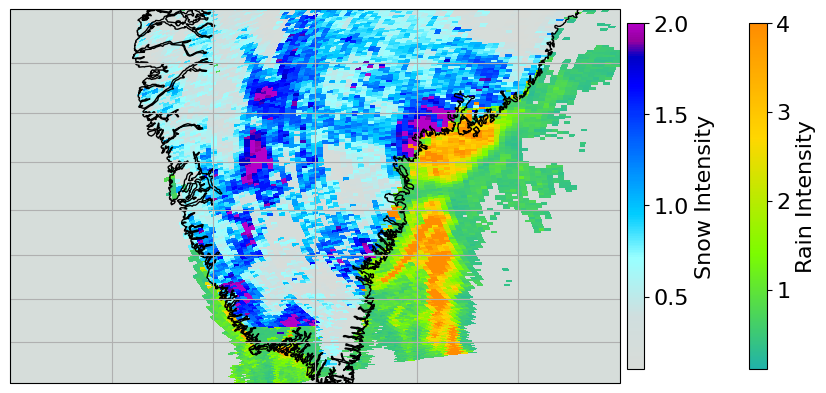

In [67]:
# Define zones and calculate the image ratio
zones = [-60, -30, 60, 68]
level = 10
im_ratio = X_rain.shape[0] / X_rain.shape[1]
X_rain_masked = np.ma.masked_where(X_rain == 0, X_rain)
X_snow_masked = np.ma.masked_where(X_snow == 0, X_snow)

# Create a figure with one subplot using the Mercator projection
fig, ax3 = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.Mercator()})

# Plot rain data
rain_plot = ax3.pcolormesh(
    Lon,
    Lat,
    X_rain_masked,
    cmap=cmap_rain,
    transform=ccrs.PlateCarree(),
    vmin=0.1,
    vmax=4,
)

# Plot snow data
snow_plot = ax3.pcolormesh(
    Lon,
    Lat,
    X_snow_masked,
    cmap=cmap_snow,
    transform=ccrs.PlateCarree(),
    vmin=0.1,
    vmax=2,
)

# Add coastlines and gridlines
ax3.coastlines()
ax3.gridlines(draw_labels=False)

# Set the extent of the plot
ax3.set_extent(zones, ccrs.PlateCarree())

# Add colorbars for rain and snow
cbar_rain = fig.colorbar(rain_plot, ax=ax3, orientation='vertical', fraction=0.046, pad=0.12, shrink = 0.45)
cbar_rain.set_label('Rain Intensity')

cbar_snow = fig.colorbar(snow_plot, ax=ax3, orientation='vertical', fraction=0.046, pad=0.01, shrink = 0.45)
cbar_snow.set_label('Snow Intensity')

plt.show()


## Appendix

### Parameter tuning of XGBDT

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE

def tune_xgb_hyperparameters(X_trn, y_trn):
    """
    Perform hyperparameter tuning for an XGBoost classifier using SMOTE for oversampling the minority class.

    Parameters:
    X_trn (pd.DataFrame or np.ndarray): Training features.
    y_trn (pd.Series or np.ndarray): Training labels.

    Returns:
    dict: Best hyperparameters found by the RandomizedSearchCV.
    """

    # Define the XGBoost model
    model_xgb = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False)

    # Define the hyperparameters grid
    param_grid = {
        'max_depth': [15, 20, 25],
        'learning_rate': [0.01, 0.3],
        'n_estimators': [100, 200, 300],
        'min_child_weight': [1, 5, 10],
    }

    # Define a scoring function (F1-score with macro averaging)
    scorer = make_scorer(f1_score, average='macro')

    # Set up Randomized Search
    grid_search = RandomizedSearchCV(estimator=model_xgb, param_distributions=param_grid, cv=5, scoring=scorer, verbose=2, n_jobs=-1, n_iter=10)

    # Fit the grid search
    grid_search.fit(X_trn,  y_trn[:, 0])

    # Print the best parameters
    print("Best parameters found: ", grid_search.best_params_)
    
    return grid_search.best_params_

In [ ]:
def create_model_reg(n_layers, hidden_units,hidden_units_f, output_unit, dropout):
    inputs = Input(shape=(18,))

    model = Sequential()
    
    # add first hidden layer
    model.add(Dense(hidden_units, activation='relu', input_shape=(18,), name = "layer_1"))
    model.add(Dropout(dropout))
    #model.add(BatchNormalization())
    
    # add remaining hidden layers
    for i in range(n_layers-1):
        model.add(Dense(hidden_units, activation='relu', name = f"fc_{i+1}"))
        model.add(Dropout(dropout))
        
    model.add(Dense(hidden_units_f, activation='relu', name = f"fc_{i+2}"))
    model.add(Dropout(dropout))    

    model.add(Dense(output_unit, activation='relu'))
    

    return model

def est_dataset(X, y, label):
    idx = (y[:,0]==label) #| (y[:,0]==0)
    X = X[idx,:]
    y = y[idx,:]
    return X, y
    

In [70]:
# For the detection step use MLP
prd_dnn = model_dtc_dnn.predict(X_tst)
prd_dnn = np.argmax(prd_dnn, axis = 1)

# For the estimation step use MLP- The detailed archicture is below
estimation_model_rain = keras.models.load_model(path_models + 'ocean_rain_reg_dnn_test.h5', compile=False)
estimation_model_snow = keras.models.load_model(path_models + 'ocean_snow_reg_dnn.h5', compile=False)

rate_rain_prd_mlp = estimation_model_rain.predict(X_tst)
rate_snow_prd_mlp = estimation_model_snow.predict(X_tst)




3185/3185 [==============================] - 3s 875us/step


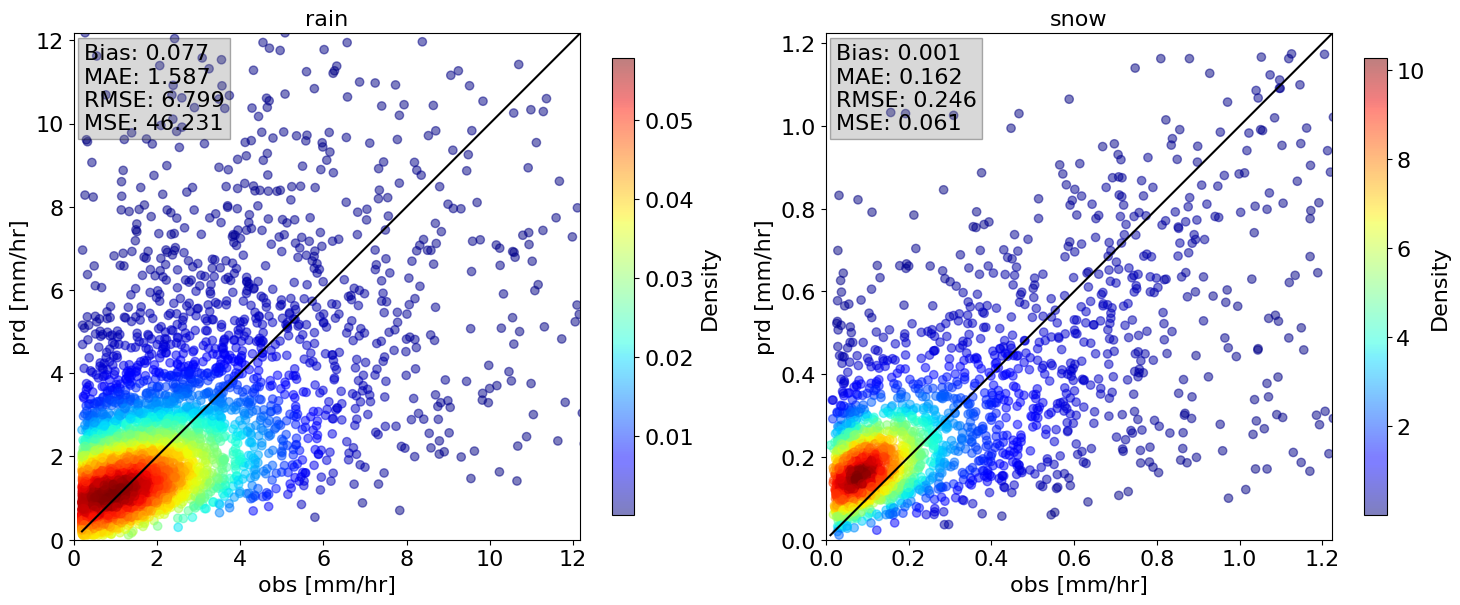

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
plt.rcParams.update({'font.size': 16})
utils.plot_density_scatter(axes[0], y_tst, rate_rain_prd_mlp.reshape(-1), prd_dnn, 1, 0.1)
utils.plot_density_scatter(axes[1], y_tst, rate_snow_prd_mlp.reshape(-1), prd_dnn, 2, 0.01)
axes[0].set_title('rain')
axes[1].set_title('snow')

plt.tight_layout()
plt.show()

### For training the MLP for regression

In [ ]:
estimation_model_rain = create_model_reg(5, 100, 10,1, 0)

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.99,
    staircase=True)

estimation_model_rain.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule),
          loss = 'mean_squared_error',
          metrics= [tf.keras.metrics.MeanAbsoluteError()])
estimation_model_rain.summary()


callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,)
]

print('\nFitting DNN (Rain regression Module):\n')
batch_size1 = 1024
history_estimation = estimation_model_rain.fit(X_trn_rain[:,:18], y_trn_rain[:,1], epochs=100, 
                                          validation_data = [X_val_rain, y_val_rain[:,1]],
                                        batch_size = batch_size1,callbacks=callbacks_list, verbose=1)
